In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create m x n matrix for Y
Y_train = np.loadtxt('./data/train.txt').astype(int)
Y_test = np.loadtxt('./data/test.txt').astype(int)

def center(train, test):
    avg = np.mean(train[:,2])
    train[:,2] = train[:,2 ] - avg
    test[:,2] = test[:, 2] - avg

center(Y_train, Y_test)

## Method 2 (Adding Bias Term a and b)
### Train Model

In [4]:
def grad_U(Ui, Yij, Vj, reg, eta, a, b):
    return eta * (np.dot(reg, Ui) - (np.dot(Vj, ((Yij) - np.dot(Ui, Vj) - a - b ))))

def grad_V(Ui, Yij, Vj, reg, eta, a, b):
    return eta * (np.dot(reg, Vj) - (np.dot(Ui, ((Yij) - np.dot(Ui, Vj) - a - b ))))

def grad_A(Ui, Yij, Vj, reg, eta, a, b):
    return -eta * ((Yij) - np.dot(Ui, Vj) - a - b  - (reg * a))
    
def grad_B(Ui, Yij, Vj, reg, eta, a, b):
    return -eta * ((Yij) - np.dot(Ui, Vj) - a - b  - (reg * b))
    
def get_err(U, V, Y, A, B, reg=0.0):
    err = 0.0
    for (i, j, Yij) in Y:
        err += .5 * (((Yij) - (np.dot(U[i-1], V[j-1]) + A[i-1] + B[j-1])) ** 2)
        
    err += 0.5 * reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 
                    + np.linalg.norm(A)**2 + np.linalg.norm(B)**2)
    
    return err / len(Y)

In [5]:
def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
  
    itr = 0
    U = np.random.uniform(-0.5, 0.5, (M, K))
    V = np.random.uniform(-0.5, 0.5, (N, K))

    A = np.random.uniform(-0.5, 0.5, (M))
    B = np.random.uniform(-0.5, 0.5, (N))
   
    curr_loss = get_err(U, V, Y, A, B)
    
    shuffled = np.random.permutation(list(range(len(Y))))
    
    for k in range(len(Y)):
        i, j, Yij = Y[shuffled[k]]
        
        # update U, V, A, B
        u = grad_U(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        v = grad_V(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        a = grad_A(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        b = grad_B(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
        
        U[i-1] = U[i-1] - u 
        V[j-1] = V[j-1] - v
        A[i-1] = A[i-1] - a
        B[j-1] = B[j-1] - b
        
    next_loss = get_err(U, V, Y, A, B)
    init = curr_loss - next_loss
    curr_delta = init
    curr_loss = next_loss
    
    while itr < max_epochs and (curr_delta / init) > eps:
        shuffled = np.random.permutation(list(range(len(Y))))
        for k in range(len(Y)): 
            i, j, Yij = Y[shuffled[k]]
            
            # update U, V, A, B
            u = grad_U(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            v = grad_V(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            a = grad_A(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])
            b = grad_B(U[i-1], Yij, V[j-1], reg, eta, A[i-1], B[j-1])

            U[i-1] = U[i-1] - u 
            V[j-1] = V[j-1] - v
            A[i-1] = A[i-1] - a
            B[j-1] = B[j-1] - b
            
        next_loss = get_err(U,V,Y, A,B)
        
        curr_delta = curr_loss - next_loss
        curr_loss = next_loss
        itr += 1
        
    return U, V, curr_loss, A, B

In [7]:
# Create 943 users x 1682 movies 
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")

k = 20
reg = 0.0
eta = 0.03 # learning rate

# Train model with no regularization
U, V, E_in, A, B = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test, A, B)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Factorizing with  943  users,  1682  movies.
Training error is: 0.06793248348724211
Test error is: 0.35363824437620983


### Test Regularization Strengths

In [10]:
# Test various values of regularization to reduce overfitting
test_reg = [10**-3, 10**-2, 10**-1, 1]

for r in test_reg:
    U_reg, V_reg, E_in_reg, A_reg, B_reg = train_model(M, N, k, eta, r, Y_train)
    E_out_reg = get_err(U_reg, V_reg, Y_test, A_reg, B_reg)
    print('Regularization = %.4f: \nTraining error is %.4f and Test error is %.4f' % (r, E_in_reg, E_out_reg))

Regularization = 0.0010: 
Training error is 0.0705 and Test error is 0.3236
Regularization = 0.0100: 
Training error is 0.0723 and Test error is 0.2817
Regularization = 0.1000: 
Training error is 0.1579 and Test error is 0.2022
Regularization = 1.0000: 
Training error is 0.2214 and Test error is 0.2253


In [11]:
# Train model with best regularization chosen from testing various strengths
reg = 0.1

U, V, E_in, A, B = train_model(M, N, k, eta, reg, Y_train)
E_out = get_err(U, V, Y_test, A, B)

print("Training error is: " + str(E_in))
print("Test error is: " + str(E_out))

Training error is: 0.16094680431835792
Test error is: 0.20054765913275374


## Visualize and Interpret Results

In [12]:
# Visualize and interpret results
def visualize(U, V):
    ''' 
        U (k x M)
        V (k x N)
    '''
    A, sigma, B = np.linalg.svd(V)
    U_tilde = np.matmul(np.transpose(A[:,:2]), U)
    V_tilde = np.matmul(np.transpose(A[:,:2]), V)
    return U_tilde, V_tilde
    
U_tilde, V_tilde = visualize(np.transpose(U), np.transpose(V))

In [13]:
colnames = ['movie_id', 'title', 'unknown', "action", "adventure", "animation", 
            "childrens", "comedy", "crime", "documentary", "drama", "fantasy", 
            "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", 
            "thriller", "war", "western"]
movie_info = pd.read_csv("data/movies.txt", names=colnames, sep='\t', header=None)

movie_to_genre = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_genre:
        movie_to_genre[row['title']] = row['unknown':'western'].to_numpy()

id_to_movie_title = movie_info['title'].tolist()
id_to_movie_title.insert(0, "NO MOVIE WITH ID 0")

movie_to_id = dict()

for i in range(1,len(id_to_movie_title)):
    if (id_to_movie_title[i] not in movie_to_id):
        movie_to_id[id_to_movie_title[i]] = i        

### Plot 10 Movies from Entire Dataset

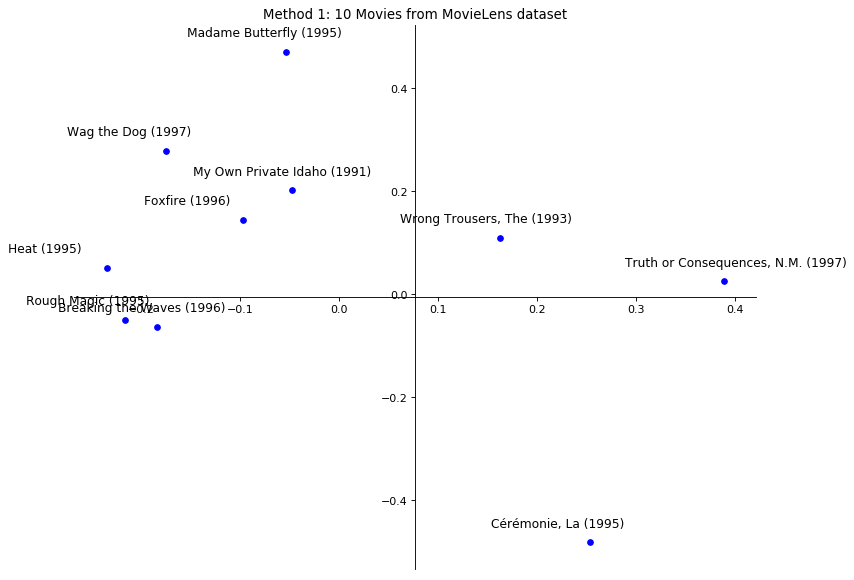

In [21]:
np.random.seed(42)
movies = np.random.choice(list(movie_to_genre.keys()), 10, replace=False)
movie_ids = [movie_to_id[m] for m in movies]

# ====================== TEN CHOSEN MOVIES PLOT ======================
V_ten = np.take(np.transpose(V_tilde), movie_ids, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_ten)):
    x = V_ten[i][0]
    y = V_ten[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, movies[i], fontsize=11)
plt.title('Method 1: 10 Movies from MovieLens dataset')
plt.show()

### Plot 10 Most Popular Movies

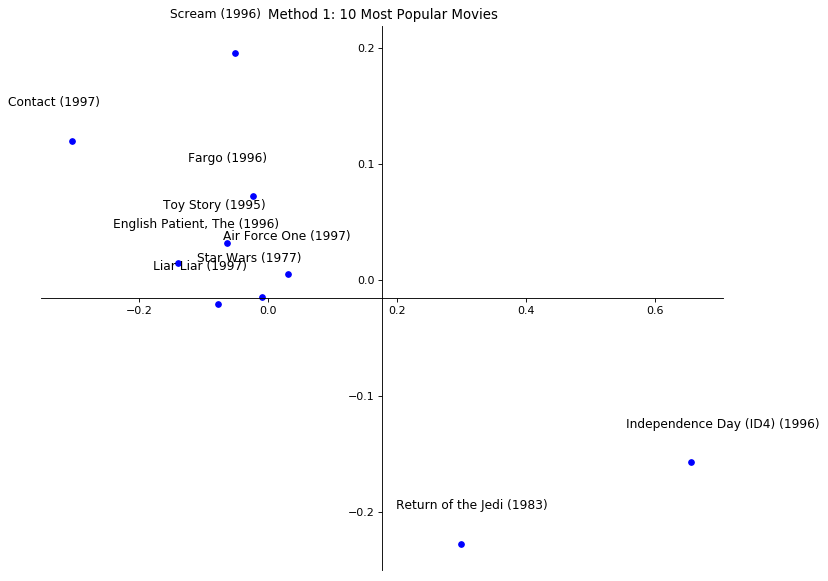

In [15]:
popular_movies = ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 
                  'Return of the Jedi (1983)', 'Liar Liar (1997)', 
                  'English Patient, The (1996)', 'Scream (1996)', 
                  'Toy Story (1995)', 'Air Force One (1997)', 
                  'Independence Day (ID4) (1996)']
pop_movies_id = [movie_to_id[m] for m in popular_movies]

# ====================== TEN MOST POPULAR MOVIES PLOT ======================
V_pop = np.take(np.transpose(V_tilde), pop_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_pop)):
    x = V_pop[i][0]
    y = V_pop[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, popular_movies[i], fontsize=11)
plt.title('Method 1: 10 Most Popular Movies')
plt.show()

### Plot 10 Best Movies

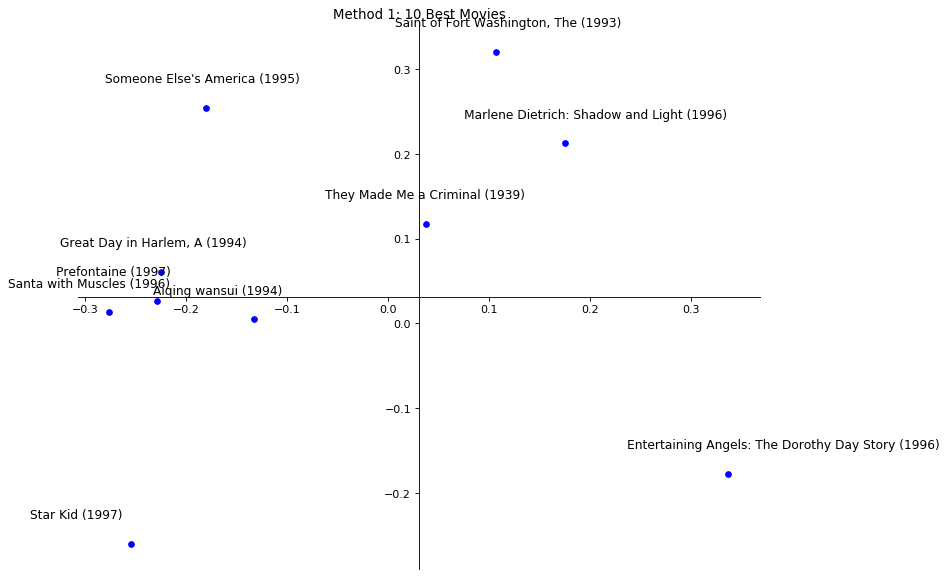

In [16]:
best_movies = ['Prefontaine (1997)', 'Santa with Muscles (1996)', 
               'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 
               'Star Kid (1997)', "Someone Else's America (1995)", 
               'Entertaining Angels: The Dorothy Day Story (1996)', 
               'Saint of Fort Washington, The (1993)', 
               'They Made Me a Criminal (1939)', 
               'Marlene Dietrich: Shadow and Light (1996) ']

best_movies_id = [movie_to_id[m] for m in best_movies]

# ====================== TEN BEST MOVIES PLOT ======================
V_best = np.take(np.transpose(V_tilde), best_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_best)):
    x = V_best[i][0]
    y = V_best[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, best_movies[i], fontsize=11)
plt.title('Method 1: 10 Best Movies')
plt.show()

### Plot 10 Movies from 3 Genres

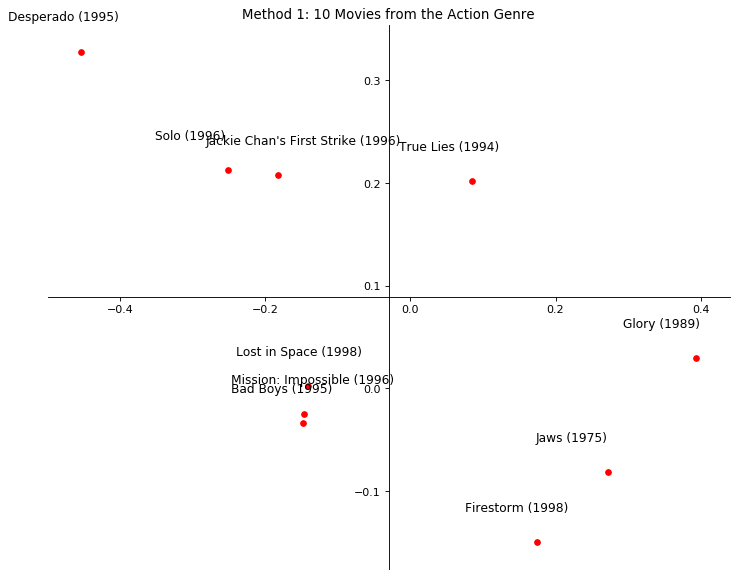

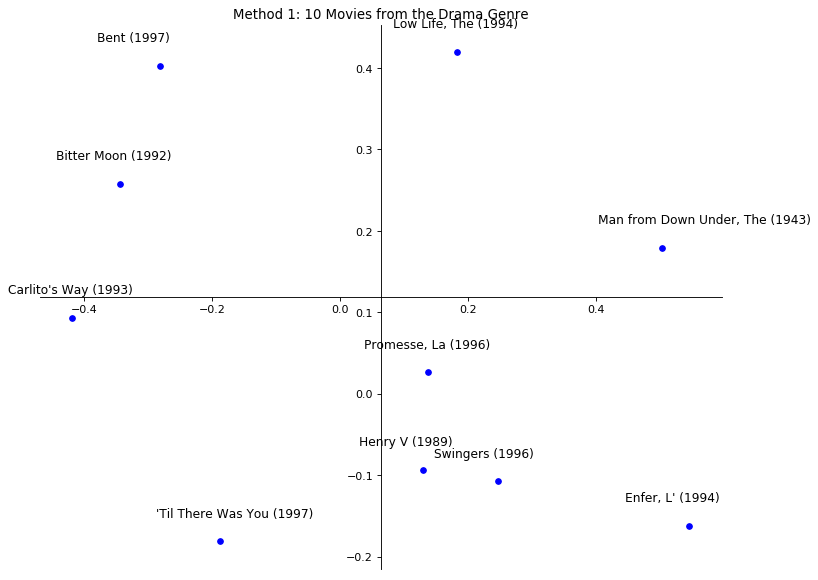

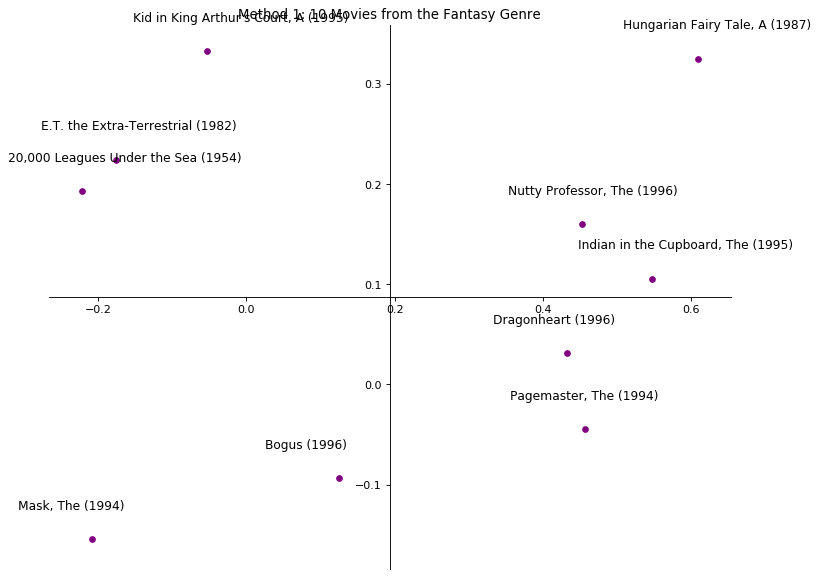

In [19]:
action = []
drama = []
fantasy = []

for key, val in movie_to_genre.items():
    if val[1]:
        action.append(key)
    if val[8]:
        drama.append(key)
    if val[9]:
        fantasy.append(key)
        
np.random.seed(42)       
action = np.random.choice(action, 10, replace=False)
action_id = [movie_to_id[m] for m in action]

np.random.seed(42)
drama = np.random.choice(drama, 10, replace=False)
drama_id = [movie_to_id[m] for m in drama]

np.random.seed(42)
fantasy = np.random.choice(fantasy, 10, replace=False)
fantasy_id = [movie_to_id[m] for m in fantasy]

# ====================== TEN MOVIES FROM EACH OF THE THREE GENRES PLOT ======================

# ACTION GENRE
V_action = np.take(np.transpose(V_tilde), action_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_action)):
    x = V_action[i][0]
    y = V_action[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.03, action[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Action Genre')
plt.show()

# DRAMA GENRE
V_drama = np.take(np.transpose(V_tilde), drama_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_drama)):
    x = V_drama[i][0]
    y = V_drama[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.03, drama[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Drama Genre')
plt.show()

# FANTASY GENRE
V_fantasy = np.take(np.transpose(V_tilde), fantasy_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_fantasy)):
    x = V_fantasy[i][0]
    y = V_fantasy[i][1]
    plt.scatter(x, y, marker='.', color='purple', s=100)
    plt.text(x - 0.1, y + 0.03, fantasy[i], fontsize=11)
plt.title('Method 1: 10 Movies from the Fantasy Genre')
plt.show()